Stats 587
HW 2
Due 11/4/2025

In [1]:
# Import statements for all problems
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, t
from scipy.special import gamma as gamma_func
import seaborn as sns
from scipy.stats import truncnorm, gamma, norm
import seaborn as sns

## Problem 1
Write a Gibbs algorithm to simulate random samples from a joint density function $f(\beta, Z_1, ..., Z_{75}, \lambda_1, ..., \lambda_{75})$, where the fully conditioned distribution functions are:

• $\beta|Z_1, ..., Z_{75}, \lambda_1, ..., \lambda_{75} \sim N\left(\frac{\sum_{i=1}^{75} \lambda_i Z_i}{\sum_{i=1}^{75} \lambda_i}, \frac{1}{\sum_{i=1}^{75} \lambda_i}\right)$

• For $i = 1, ..., 50$: $Z_i|\beta, \lambda_1, ..., \lambda_{75} \sim$ left truncated normal at 0

• For $i = 51, ..., 75$: $Z_i|\beta, \lambda_1, ..., \lambda_{75} \sim$ right truncated normal at 0

• For $i = 1, ..., 75$: $\lambda_i|\beta, Z_1, ..., Z_{75} \sim \Gamma\left(\frac{5}{2}, \frac{2}{4 + (Z_i + \beta)^2}\right)$

### Problem 1a
Implement the Gibbs algorithm and plot the trace and density of: $\beta$, $Z_1$, $Z_{51}$, $\lambda_1$ (8 plots)

Running Gibbs sampler...
Generated 8000 samples after burn-in
Plots saved as 'problem1a_plots.png'


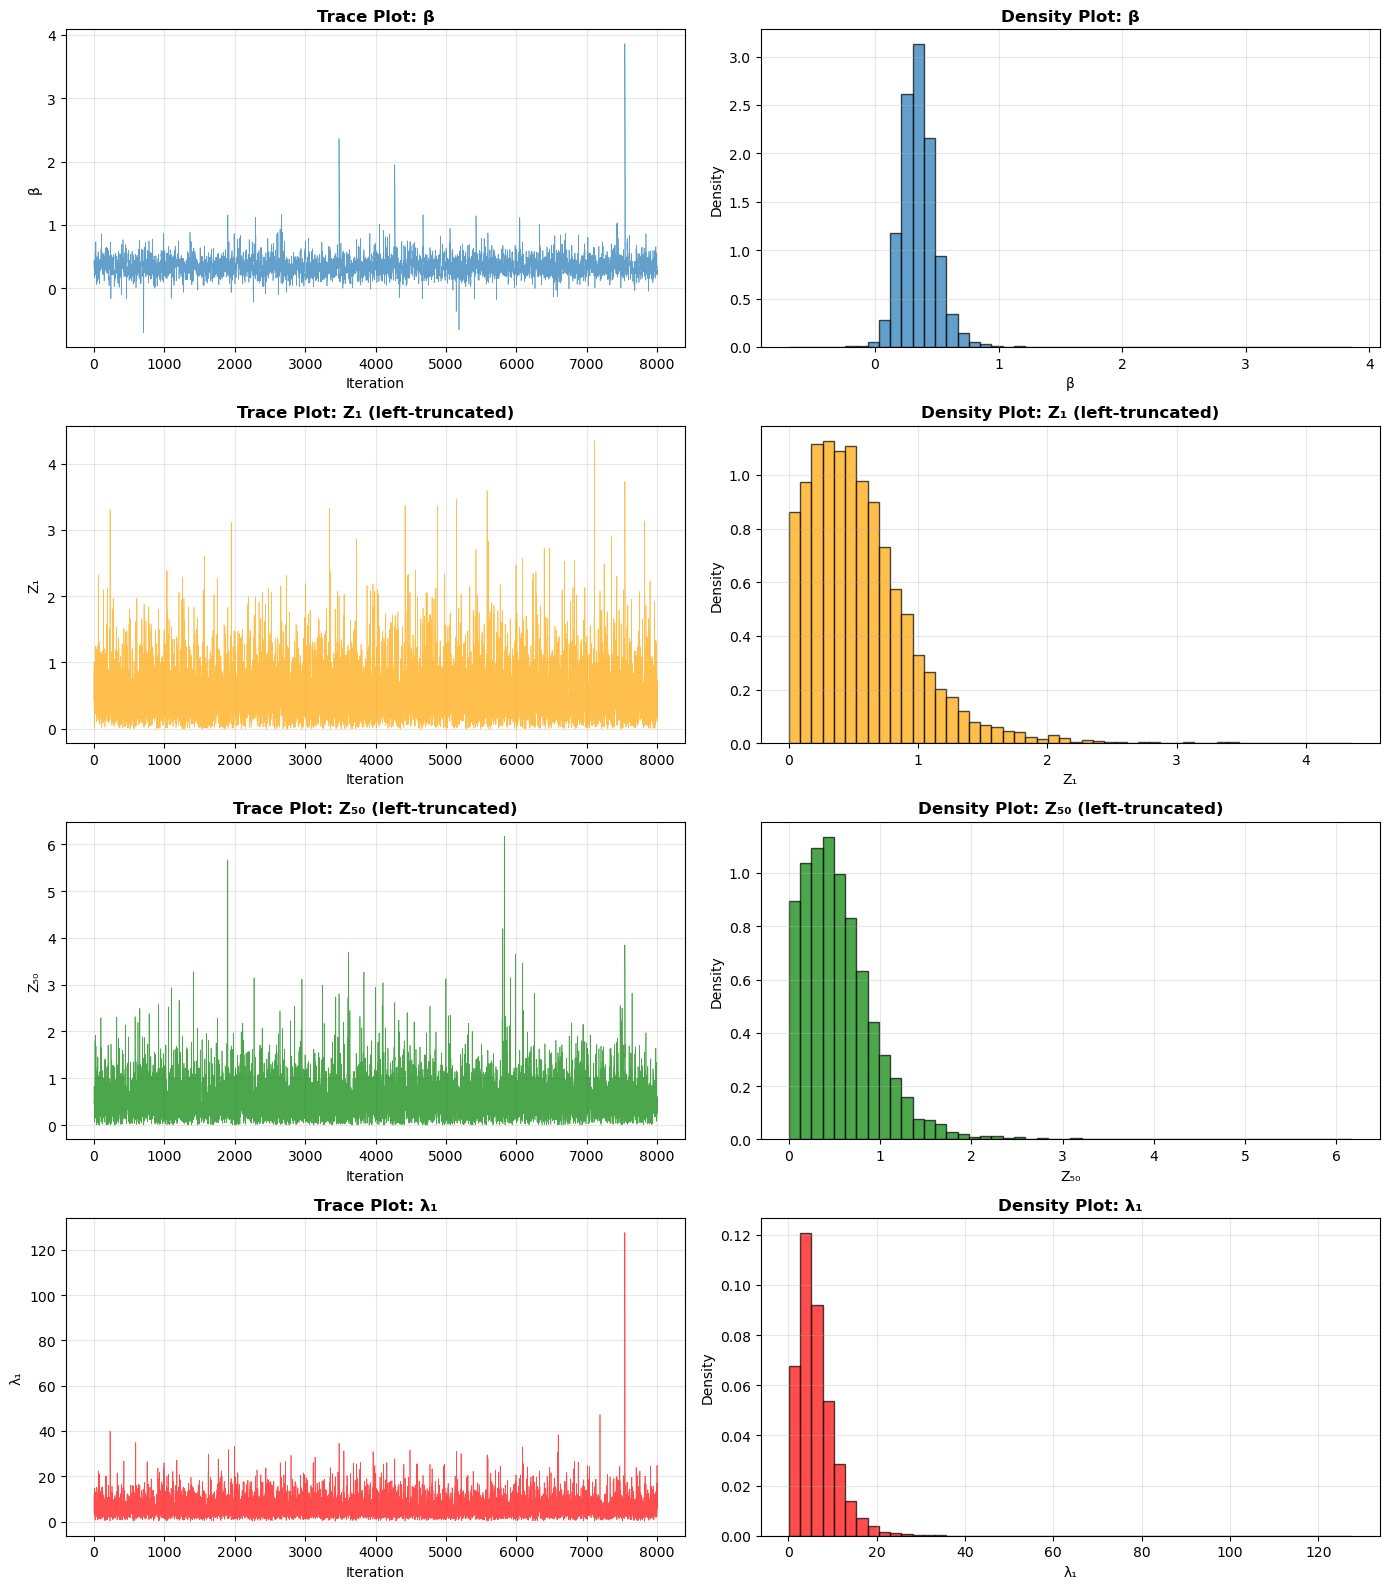


SUMMARY STATISTICS
β    - Mean: 0.3548, SD: 0.1642
Z₁   - Mean: 0.5545, SD: 0.4142
Z₅₀  - Mean: 0.5585, SD: 0.4260
λ₁   - Mean: 6.3553, SD: 4.6179


In [ ]:
np.random.seed(42)

def sample_truncated_normal(mean, sd, lower=-np.inf, upper=np.inf):
    a = (lower - mean) / sd
    b = (upper - mean) / sd
    return truncnorm.rvs(a, b, loc=mean, scale=sd)

def gibbs_sampler_problem1(n_iter=10000, burn_in=2000):
    # Initialize parameters
    n = 75
    
    # Starting values
    beta = 0.0
    Z = np.zeros(n)
    # Initialize Z with appropriate signs based on truncation
    Z[:50] = np.abs(np.random.randn(50))  # positive for left-truncated
    Z[50:] = -np.abs(np.random.randn(25))  # negative for right-truncated
    lambda_vec = np.ones(n)
    
    # Storage for samples (after burn-in)
    samples = {
        'beta': np.zeros(n_iter - burn_in),
        'Z': np.zeros((n_iter - burn_in, n)),
        'lambda': np.zeros((n_iter - burn_in, n))
    }
    
    # Gibbs sampling
    for t in range(n_iter):
        # Step 1: Sample beta
        # beta | Z, lambda ~ N(sum(lambda_i * Z_i) / sum(lambda_i), 1 / sum(lambda_i))
        sum_lambda = np.sum(lambda_vec)
        sum_lambda_Z = np.sum(lambda_vec * Z)
        
        beta_mean = sum_lambda_Z / sum_lambda
        beta_var = 1.0 / sum_lambda
        beta_sd = np.sqrt(beta_var)
        
        beta = np.random.normal(beta_mean, beta_sd)
        
        # Step 2: Sample Z_i for i = 1, ..., 75
        for i in range(n):
            # Z_i | beta, lambda ~ N(beta, 1/lambda_i)
            Z_mean = beta
            Z_sd = np.sqrt(1.0 / lambda_vec[i])
            
            if i < 50:
                # Left-truncated at 0 (Z_i > 0)
                Z[i] = sample_truncated_normal(Z_mean, Z_sd, lower=0, upper=np.inf)
            else:
                # Right-truncated at 0 (Z_i < 0)
                Z[i] = sample_truncated_normal(Z_mean, Z_sd, lower=-np.inf, upper=0)
        
        # Step 3: Sample lambda_i for i = 1, ..., 75
        # lambda_i | beta, Z ~ Gamma(5/2, 2/(4 + (Z_i + beta)^2))
        for i in range(n):
            shape = 5.0 / 2.0
            rate = 2.0 / (4.0 + (Z[i] + beta)**2)
            # Note: scipy uses scale = 1/rate
            scale = 1.0 / rate
            lambda_vec[i] = gamma.rvs(shape, scale=scale)
        
        # Store samples after burn-in
        if t >= burn_in:
            idx = t - burn_in
            samples['beta'][idx] = beta
            samples['Z'][idx, :] = Z
            samples['lambda'][idx, :] = lambda_vec
    
    return samples

# Run the Gibbs sampler
print("Running Gibbs sampler...")
samples = gibbs_sampler_problem1(n_iter=10000, burn_in=2000)
print(f"Generated {len(samples['beta'])} samples after burn-in")

# Create the 8 required plots
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

# Plot 1: Trace plot for beta
axes[0, 0].plot(samples['beta'], linewidth=0.5, alpha=0.7)
axes[0, 0].set_title('Trace Plot: β', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('β')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Density plot for beta
axes[0, 1].hist(samples['beta'], bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Density Plot: β', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('β')
axes[0, 1].set_ylabel('Density')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Trace plot for Z_1
axes[1, 0].plot(samples['Z'][:, 0], linewidth=0.5, alpha=0.7, color='orange')
axes[1, 0].set_title('Trace Plot: Z₁ (left-truncated)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Z₁')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Density plot for Z_1
axes[1, 1].hist(samples['Z'][:, 0], bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')
axes[1, 1].set_title('Density Plot: Z₁ (left-truncated)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Z₁')
axes[1, 1].set_ylabel('Density')
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Trace plot for Z_50
axes[2, 0].plot(samples['Z'][:, 49], linewidth=0.5, alpha=0.7, color='green')
axes[2, 0].set_title('Trace Plot: Z₅₀ (left-truncated)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Iteration')
axes[2, 0].set_ylabel('Z₅₀')
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Density plot for Z_50
axes[2, 1].hist(samples['Z'][:, 49], bins=50, density=True, alpha=0.7, edgecolor='black', color='green')
axes[2, 1].set_title('Density Plot: Z₅₀ (left-truncated)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Z₅₀')
axes[2, 1].set_ylabel('Density')
axes[2, 1].grid(True, alpha=0.3)

# Plot 7: Trace plot for lambda_1
axes[3, 0].plot(samples['lambda'][:, 0], linewidth=0.5, alpha=0.7, color='red')
axes[3, 0].set_title('Trace Plot: λ₁', fontsize=12, fontweight='bold')
axes[3, 0].set_xlabel('Iteration')
axes[3, 0].set_ylabel('λ₁')
axes[3, 0].grid(True, alpha=0.3)

# Plot 8: Density plot for lambda_1
axes[3, 1].hist(samples['lambda'][:, 0], bins=50, density=True, alpha=0.7, edgecolor='black', color='red')
axes[3, 1].set_title('Density Plot: λ₁', fontsize=12, fontweight='bold')
axes[3, 1].set_xlabel('λ₁')
axes[3, 1].set_ylabel('Density')
axes[3, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problem1a_plots.png', dpi=300, bbox_inches='tight')
print("Plots saved as 'problem1a_plots.png'")
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"β    - Mean: {np.mean(samples['beta']):.4f}, SD: {np.std(samples['beta']):.4f}")
print(f"Z₁   - Mean: {np.mean(samples['Z'][:, 0]):.4f}, SD: {np.std(samples['Z'][:, 0]):.4f}")
print(f"Z₅₀  - Mean: {np.mean(samples['Z'][:, 49]):.4f}, SD: {np.std(samples['Z'][:, 49]):.4f}")
print(f"λ₁   - Mean: {np.mean(samples['lambda'][:, 0]):.4f}, SD: {np.std(samples['lambda'][:, 0]):.4f}")
print("="*60)

### Problem 1b
Based on the Monte Carlo method, compute $\hat{F}(0.75) - \hat{F}(-0.2)$ using the formula:

$$\hat{f}(\beta) = \frac{1}{T} \sum_{t=1}^{T} f(\beta|Z_1^{(t)}, ..., Z_{75}^{(t)}, \lambda_1^{(t)}, ..., \lambda_{75}^{(t)})$$

Problem 1(b): Estimating F̂(0.75) - F̂(-0.2)

Running Gibbs sampler with 10,000 iterations (2,000 burn-in)...
✓ Generated 8000 samples after burn-in

----------------------------------------------------------------------
RESULTS
----------------------------------------------------------------------
F̂(0.75) - F̂(-0.2) = 0.978342

Interpretation:
The estimated probability that β falls in the interval [-0.2, 0.75]
is approximately 0.9783 or 97.83%
----------------------------------------------------------------------

DIAGNOSTIC INFORMATION
----------------------------------------------------------------------
Mean of conditional means:     0.358708
Mean of conditional SDs:       0.047542
Standard deviation of P(t):    0.135674
Min probability across iters:  0.000000
Max probability across iters:  1.000000
----------------------------------------------------------------------

✓ Visualization saved as 'problem1b_results.png'


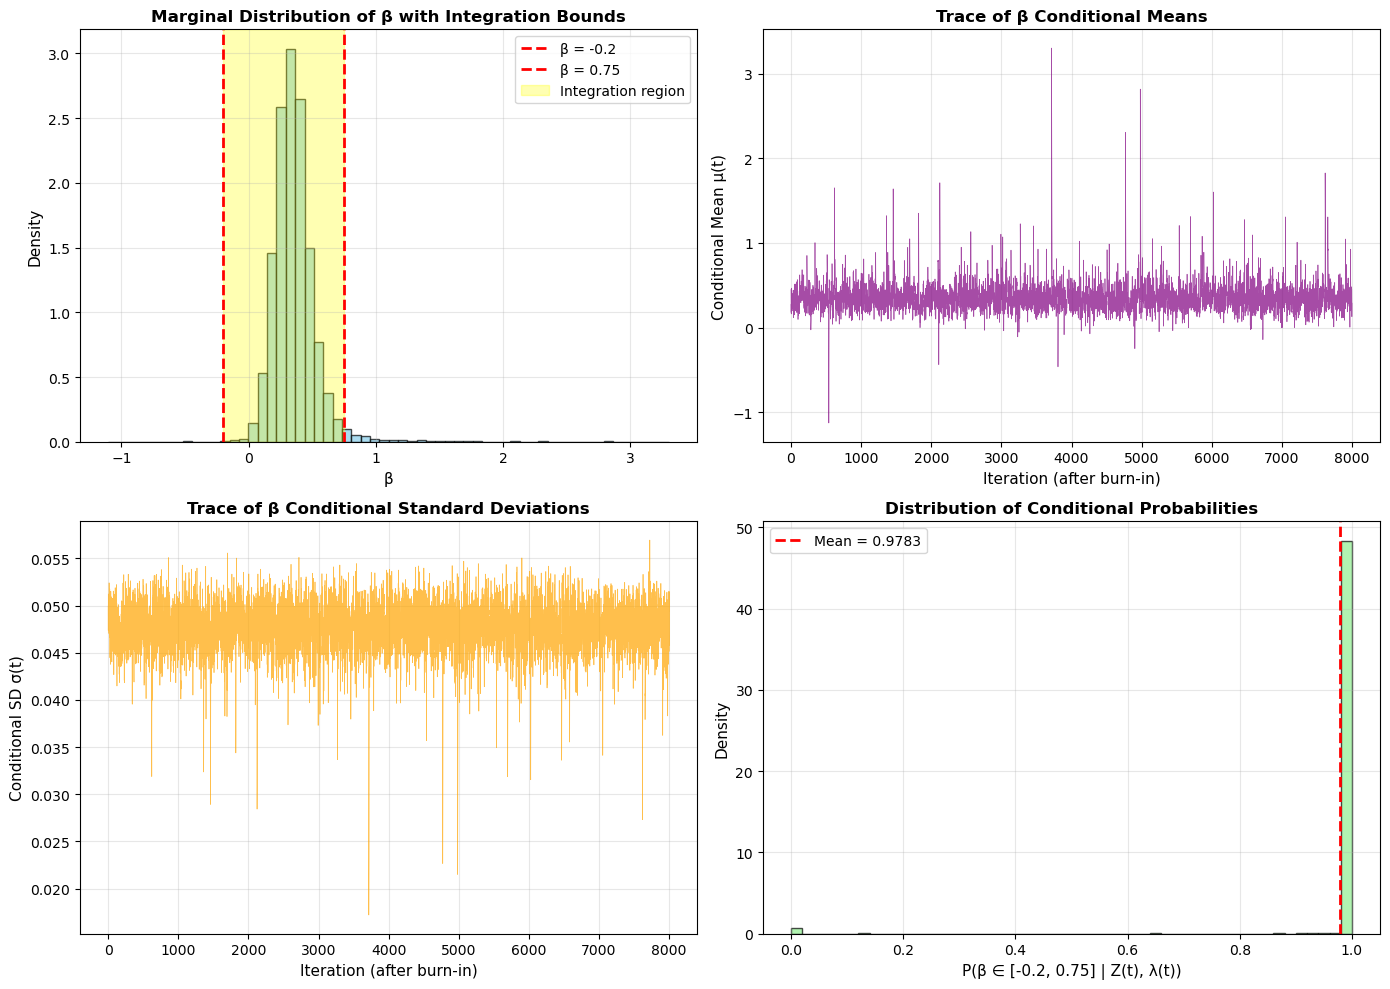


VERIFICATION: Alternative Method (Empirical CDF from samples)
Direct empirical estimate: 0.977875
Monte Carlo estimate:      0.978342
Difference:                0.000467

Note: Both methods should give similar results.
The Monte Carlo method uses the full conditional distributions,
while the empirical method just counts samples in the interval.


In [3]:
def sample_truncated_normal(mean, sd, lower=-np.inf, upper=np.inf):
    """
    Sample from a truncated normal distribution
    """
    a = (lower - mean) / sd
    b = (upper - mean) / sd
    return truncnorm.rvs(a, b, loc=mean, scale=sd)

def gibbs_sampler_problem1b(n_iter=10000, burn_in=2000):
    """
    Gibbs sampler for Problem 1 with storage for conditional parameters
    
    Returns:
    --------
    samples: dictionary containing:
        - beta samples
        - conditional means and variances for beta at each iteration
    """
    n = 75
    
    # Initialize
    beta = 0.0
    Z = np.zeros(n)
    Z[:50] = np.abs(np.random.randn(50))
    Z[50:] = -np.abs(np.random.randn(25))
    lambda_vec = np.ones(n)
    
    # Storage
    samples = {
        'beta': np.zeros(n_iter - burn_in),
        'Z': np.zeros((n_iter - burn_in, n)),
        'lambda': np.zeros((n_iter - burn_in, n)),
        'beta_cond_mean': np.zeros(n_iter - burn_in),  # Store conditional means
        'beta_cond_sd': np.zeros(n_iter - burn_in)     # Store conditional SDs
    }
    
    # Gibbs sampling
    for t in range(n_iter):
        # Step 1: Sample beta
        sum_lambda = np.sum(lambda_vec)
        sum_lambda_Z = np.sum(lambda_vec * Z)
        
        beta_mean = sum_lambda_Z / sum_lambda
        beta_var = 1.0 / sum_lambda
        beta_sd = np.sqrt(beta_var)
        
        beta = np.random.normal(beta_mean, beta_sd)
        
        # Step 2: Sample Z_i
        for i in range(n):
            Z_mean = beta
            Z_sd = np.sqrt(1.0 / lambda_vec[i])
            
            if i < 50:
                Z[i] = sample_truncated_normal(Z_mean, Z_sd, lower=0, upper=np.inf)
            else:
                Z[i] = sample_truncated_normal(Z_mean, Z_sd, lower=-np.inf, upper=0)
        
        # Step 3: Sample lambda_i
        for i in range(n):
            shape = 5.0 / 2.0
            rate = 2.0 / (4.0 + (Z[i] + beta)**2)
            scale = 1.0 / rate
            lambda_vec[i] = gamma.rvs(shape, scale=scale)
        
        # Store samples and conditional parameters after burn-in
        if t >= burn_in:
            idx = t - burn_in
            samples['beta'][idx] = beta
            samples['Z'][idx, :] = Z
            samples['lambda'][idx, :] = lambda_vec
            samples['beta_cond_mean'][idx] = beta_mean
            samples['beta_cond_sd'][idx] = beta_sd
    
    return samples

def compute_marginal_cdf_difference(samples, lower_bound=-0.2, upper_bound=0.75):
    """
    Compute F_hat(upper) - F_hat(lower) using Monte Carlo estimation
    
    Formula: (1/T) * sum_{t=1}^T [ Phi((upper - mu^(t)) / sigma^(t)) 
                                    - Phi((lower - mu^(t)) / sigma^(t)) ]
    
    where mu^(t) and sigma^(t) are the conditional mean and SD for beta at iteration t
    """
    T = len(samples['beta_cond_mean'])
    
    # For each iteration t, compute the probability that beta falls in [lower, upper]
    # given the conditional distribution from that iteration
    probabilities = np.zeros(T)
    
    for t in range(T):
        mu_t = samples['beta_cond_mean'][t]
        sigma_t = samples['beta_cond_sd'][t]
        
        # Standardize the bounds
        z_upper = (upper_bound - mu_t) / sigma_t
        z_lower = (lower_bound - mu_t) / sigma_t
        
        # Compute Phi(z_upper) - Phi(z_lower)
        # This is the probability that beta is in [lower, upper] given iteration t's conditional
        prob_t = norm.cdf(z_upper) - norm.cdf(z_lower)
        probabilities[t] = prob_t
    
    # Average across all iterations
    F_hat_diff = np.mean(probabilities)
    
    return F_hat_diff, probabilities

# Run the Gibbs sampler
print("="*70)
print("Problem 1(b): Estimating F̂(0.75) - F̂(-0.2)")
print("="*70)
print("\nRunning Gibbs sampler with 10,000 iterations (2,000 burn-in)...")
samples = gibbs_sampler_problem1b(n_iter=10000, burn_in=2000)
print(f"✓ Generated {len(samples['beta'])} samples after burn-in\n")

# Compute the CDF difference
lower = -0.2
upper = 0.75
F_hat_diff, probabilities = compute_marginal_cdf_difference(samples, lower, upper)

print("-"*70)
print("RESULTS")
print("-"*70)
print(f"F̂(0.75) - F̂(-0.2) = {F_hat_diff:.6f}")
print(f"\nInterpretation:")
print(f"The estimated probability that β falls in the interval [-0.2, 0.75]")
print(f"is approximately {F_hat_diff:.4f} or {F_hat_diff*100:.2f}%")
print("-"*70)

# Additional diagnostics
print("\nDIAGNOSTIC INFORMATION")
print("-"*70)
print(f"Mean of conditional means:     {np.mean(samples['beta_cond_mean']):.6f}")
print(f"Mean of conditional SDs:       {np.mean(samples['beta_cond_sd']):.6f}")
print(f"Standard deviation of P(t):    {np.std(probabilities):.6f}")
print(f"Min probability across iters:  {np.min(probabilities):.6f}")
print(f"Max probability across iters:  {np.max(probabilities):.6f}")
print("-"*70)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram of beta samples with shaded region
axes[0, 0].hist(samples['beta'], bins=60, density=True, alpha=0.7, 
                edgecolor='black', color='skyblue')
axes[0, 0].axvline(x=lower, color='red', linestyle='--', linewidth=2, label=f'β = {lower}')
axes[0, 0].axvline(x=upper, color='red', linestyle='--', linewidth=2, label=f'β = {upper}')
axes[0, 0].axvspan(lower, upper, alpha=0.3, color='yellow', label='Integration region')
axes[0, 0].set_xlabel('β', fontsize=11)
axes[0, 0].set_ylabel('Density', fontsize=11)
axes[0, 0].set_title('Marginal Distribution of β with Integration Bounds', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Trace of conditional means
axes[0, 1].plot(samples['beta_cond_mean'], linewidth=0.5, alpha=0.7, color='purple')
axes[0, 1].set_xlabel('Iteration (after burn-in)', fontsize=11)
axes[0, 1].set_ylabel('Conditional Mean μ(t)', fontsize=11)
axes[0, 1].set_title('Trace of β Conditional Means', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Trace of conditional standard deviations
axes[1, 0].plot(samples['beta_cond_sd'], linewidth=0.5, alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Iteration (after burn-in)', fontsize=11)
axes[1, 0].set_ylabel('Conditional SD σ(t)', fontsize=11)
axes[1, 0].set_title('Trace of β Conditional Standard Deviations', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Histogram of probabilities from each iteration
axes[1, 1].hist(probabilities, bins=50, density=True, alpha=0.7, 
                edgecolor='black', color='lightgreen')
axes[1, 1].axvline(x=F_hat_diff, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean = {F_hat_diff:.4f}')
axes[1, 1].set_xlabel('P(β ∈ [-0.2, 0.75] | Z(t), λ(t))', fontsize=11)
axes[1, 1].set_ylabel('Density', fontsize=11)
axes[1, 1].set_title('Distribution of Conditional Probabilities', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problem1b_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'problem1b_results.png'")
plt.show()

# Verification: Alternative simple method (direct empirical CDF)
empirical_prob = np.mean((samples['beta'] >= lower) & (samples['beta'] <= upper))
print("\n" + "="*70)
print("VERIFICATION: Alternative Method (Empirical CDF from samples)")
print("="*70)
print(f"Direct empirical estimate: {empirical_prob:.6f}")
print(f"Monte Carlo estimate:      {F_hat_diff:.6f}")
print(f"Difference:                {abs(empirical_prob - F_hat_diff):.6f}")
print("\nNote: Both methods should give similar results.")
print("The Monte Carlo method uses the full conditional distributions,")
print("while the empirical method just counts samples in the interval.")
print("="*70)


## Problem 2
We want to estimate the integral $I = \int_{-\infty}^{\infty} x^3 p(x) dx$ where $p(x)$ is the pdf of $N(2,1)$.

### Problem 2a
Calculate the exact value of $I$.

In [4]:
# Solution for Problem 2a - Exact calculation

# For X ~ N(μ, σ²), E[X³] = μ³ + 3μσ²
# Here μ = 2, σ² = 1
mu = 2
sigma_sq = 1

I_exact = mu**3 + 3*mu*sigma_sq
print(f"Exact value of I = E[X³] where X ~ N(2,1): {I_exact}")

# Alternative calculation: E[X³] = μ³ + 3μσ² = 2³ + 3(2)(1) = 8 + 6 = 14

Exact value of I = E[X³] where X ~ N(2,1): 14


### Problem 2b
Estimate $I$ using Monte-Carlo approximation with Metropolis-Hastings and different proposal distributions (n = 5000):

- $g(\cdot|x_t) = N(2,1)$
- $g(\cdot|x_t) = N(0,1)$
- $g(\cdot|x_t) = N(x_t, 1)$
- $g(\cdot|x_t) = N(x_t, 5)$

In [ ]:
import numpy as np
from scipy import stats

# Problem 2(a) - Exact value
I_exact = 14

# Problem 2(b) - Metropolis-Hastings Implementation

def metropolis_hastings_case1(n_samples=5000):
    """
    Case 1: Independent proposal g(·|x_t) = N(2, 1)
    """
    samples = np.zeros(n_samples)
    samples[0] = 2.0  # Initial value
    n_accepted = 0
    
    # Target: p(x) = N(2, 1)
    target_mean = 2.0
    target_var = 1.0
    
    # Proposal: g(·|x_t) = N(2, 1) (independent)
    proposal_mean = 2.0
    proposal_var = 1.0
    
    for t in range(1, n_samples):
        x_current = samples[t-1]
        
        # Step 1: Propose x* from N(2, 1)
        x_star = np.random.normal(proposal_mean, np.sqrt(proposal_var))
        
        # Step 2: Compute acceptance ratio
        # alpha = [p(x*) * g(x_current|x*)] / [p(x_current) * g(x*|x_current)]
        
        # Since proposal = target, this simplifies to 1
        # But let's compute it explicitly:
        p_star = stats.norm.pdf(x_star, target_mean, np.sqrt(target_var))
        p_current = stats.norm.pdf(x_current, target_mean, np.sqrt(target_var))
        
        g_reverse = stats.norm.pdf(x_current, proposal_mean, np.sqrt(proposal_var))
        g_forward = stats.norm.pdf(x_star, proposal_mean, np.sqrt(proposal_var))
        
        alpha = min(1.0, (p_star * g_reverse) / (p_current * g_forward))
        
        # Step 3: Accept or reject
        if np.random.uniform() < alpha:
            samples[t] = x_star
            n_accepted += 1
        else:
            samples[t] = x_current
    
    acceptance_rate = n_accepted / (n_samples - 1)
    I_estimate = np.mean(samples**3)
    
    return samples, acceptance_rate, I_estimate


def metropolis_hastings_case2(n_samples=5000):
    """
    Case 2: Independent proposal g(·|x_t) = N(0, 1)
    """
    samples = np.zeros(n_samples)
    samples[0] = 2.0  # Initial value
    n_accepted = 0
    
    # Target: p(x) = N(2, 1)
    target_mean = 2.0
    target_var = 1.0
    
    # Proposal: g(·|x_t) = N(0, 1) (independent)
    proposal_mean = 0.0
    proposal_var = 1.0
    
    for t in range(1, n_samples):
        x_current = samples[t-1]
        
        # Step 1: Propose x* from N(0, 1)
        x_star = np.random.normal(proposal_mean, np.sqrt(proposal_var))
        
        # Step 2: Compute acceptance ratio
        p_star = stats.norm.pdf(x_star, target_mean, np.sqrt(target_var))
        p_current = stats.norm.pdf(x_current, target_mean, np.sqrt(target_var))
        
        g_reverse = stats.norm.pdf(x_current, proposal_mean, np.sqrt(proposal_var))
        g_forward = stats.norm.pdf(x_star, proposal_mean, np.sqrt(proposal_var))
        
        alpha = min(1.0, (p_star * g_reverse) / (p_current * g_forward))
        
        # Step 3: Accept or reject
        if np.random.uniform() < alpha:
            samples[t] = x_star
            n_accepted += 1
        else:
            samples[t] = x_current
    
    acceptance_rate = n_accepted / (n_samples - 1)
    I_estimate = np.mean(samples**3)
    
    return samples, acceptance_rate, I_estimate


def metropolis_hastings_case3(n_samples=5000):
    """
    Case 3: Random walk proposal g(·|x_t) = N(x_t, 1)
    """
    samples = np.zeros(n_samples)
    samples[0] = 2.0  # Initial value
    n_accepted = 0
    
    # Target: p(x) = N(2, 1)
    target_mean = 2.0
    target_var = 1.0
    
    # Proposal: g(·|x_t) = N(x_t, 1) (random walk, symmetric)
    proposal_var = 1.0
    
    for t in range(1, n_samples):
        x_current = samples[t-1]
        
        # Step 1: Propose x* from N(x_current, 1)
        x_star = np.random.normal(x_current, np.sqrt(proposal_var))
        
        # Step 2: Compute acceptance ratio
        # For symmetric proposals, g cancels out
        # alpha = p(x*) / p(x_current)
        
        p_star = stats.norm.pdf(x_star, target_mean, np.sqrt(target_var))
        p_current = stats.norm.pdf(x_current, target_mean, np.sqrt(target_var))
        
        alpha = min(1.0, p_star / p_current)
        
        # Step 3: Accept or reject
        if np.random.uniform() < alpha:
            samples[t] = x_star
            n_accepted += 1
        else:
            samples[t] = x_current
    
    acceptance_rate = n_accepted / (n_samples - 1)
    I_estimate = np.mean(samples**3)
    
    return samples, acceptance_rate, I_estimate


def metropolis_hastings_case4(n_samples=5000):
    """
    Case 4: Random walk proposal g(·|x_t) = N(x_t, 5)
    """
    samples = np.zeros(n_samples)
    samples[0] = 2.0  # Initial value
    n_accepted = 0
    
    # Target: p(x) = N(2, 1)
    target_mean = 2.0
    target_var = 1.0
    
    # Proposal: g(·|x_t) = N(x_t, 5) (random walk, symmetric)
    proposal_var = 5.0
    
    for t in range(1, n_samples):
        x_current = samples[t-1]
        
        # Step 1: Propose x* from N(x_current, 5)
        x_star = np.random.normal(x_current, np.sqrt(proposal_var))
        
        # Step 2: Compute acceptance ratio
        # For symmetric proposals, g cancels out
        # alpha = p(x*) / p(x_current)
        
        p_star = stats.norm.pdf(x_star, target_mean, np.sqrt(target_var))
        p_current = stats.norm.pdf(x_current, target_mean, np.sqrt(target_var))
        
        alpha = min(1.0, p_star / p_current)
        
        # Step 3: Accept or reject
        if np.random.uniform() < alpha:
            samples[t] = x_star
            n_accepted += 1
        else:
            samples[t] = x_current
    
    acceptance_rate = n_accepted / (n_samples - 1)
    I_estimate = np.mean(samples**3)
    
    return samples, acceptance_rate, I_estimate


# Run all four cases
print("="*75)
print("Problem 2(b): Metropolis-Hastings Estimation")
print("="*75)
print(f"Target: p(x) = N(2, 1)")
print(f"Exact value: I = {I_exact}")
print(f"Sample size: n = 5000")
print("="*75)

np.random.seed(42)

# Case 1: g(·|x_t) = N(2, 1)
print("\nCase 1: g(·|x_t) = N(2, 1) [Independent]")
samples1, acc_rate1, I_est1 = metropolis_hastings_case1()
print(f"  Acceptance Rate: {acc_rate1:.4f}")
print(f"  Estimate of I:   {I_est1:.6f}")

# Case 2: g(·|x_t) = N(0, 1)
print("\nCase 2: g(·|x_t) = N(0, 1) [Independent]")
samples2, acc_rate2, I_est2 = metropolis_hastings_case2()
print(f"  Acceptance Rate: {acc_rate2:.4f}")
print(f"  Estimate of I:   {I_est2:.6f}")

# Case 3: g(·|x_t) = N(x_t, 1)
print("\nCase 3: g(·|x_t) = N(x_t, 1) [Random Walk]")
samples3, acc_rate3, I_est3 = metropolis_hastings_case3()
print(f"  Acceptance Rate: {acc_rate3:.4f}")
print(f"  Estimate of I:   {I_est3:.6f}")

# Case 4: g(·|x_t) = N(x_t, 5)
print("\nCase 4: g(·|x_t) = N(x_t, 5) [Random Walk]")
samples4, acc_rate4, I_est4 = metropolis_hastings_case4()
print(f"  Acceptance Rate: {acc_rate4:.4f}")
print(f"  Estimate of I:   {I_est4:.6f}")

# Summary table with the 8 requested values
print("\n" + "="*75)
print("SUMMARY: 8 Values Requested")
print("="*75)
print(f"{'Proposal g(·|x_t)':<25} {'Acceptance Rate':<20} {'Estimate of I':<15}")
print("-"*75)
print(f"{'N(2, 1) [Independent]':<25} {acc_rate1:>8.4f}           {I_est1:>12.6f}")
print(f"{'N(0, 1) [Independent]':<25} {acc_rate2:>8.4f}           {I_est2:>12.6f}")
print(f"{'N(x_t, 1) [Random Walk]':<25} {acc_rate3:>8.4f}           {I_est3:>12.6f}")
print(f"{'N(x_t, 5) [Random Walk]':<25} {acc_rate4:>8.4f}           {I_est4:>12.6f}")
print("-"*75)
print(f"{'Exact Value':<25} {'':20} {I_exact:>12.6f}")
print("="*75)


Problem 2(b): Metropolis-Hastings Estimation
Target: p(x) = N(2, 1)
Exact value: I = 14
Sample size: n = 5000

Case 1: g(·|x_t) = N(2, 1) [Independent]
  Acceptance Rate: 1.0000
  Estimate of I:   14.135358

Case 2: g(·|x_t) = N(0, 1) [Independent]
  Acceptance Rate: 0.1574
  Estimate of I:   14.341791

Case 3: g(·|x_t) = N(x_t, 1) [Random Walk]
  Acceptance Rate: 0.7003
  Estimate of I:   14.593511

Case 4: g(·|x_t) = N(x_t, 5) [Random Walk]
  Acceptance Rate: 0.4657
  Estimate of I:   14.212411

SUMMARY: 8 Values Requested
Proposal g(·|x_t)         Acceptance Rate      Estimate of I  
---------------------------------------------------------------------------
N(2, 1) [Independent]       1.0000              14.135358
N(0, 1) [Independent]       0.1574              14.341791
N(x_t, 1) [Random Walk]     0.7003              14.593511
N(x_t, 5) [Random Walk]     0.4657              14.212411
---------------------------------------------------------------------------
Exact Value           

## Problem 3
Simulate bivariate copulas with correlation matrix $\begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$.

### Problem 3a
Write a program to simulate bivariate Gaussian copulas with correlation matrix $\begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$.

In [6]:
import numpy as np
from scipy import stats

def simulate_gaussian_copula(n_samples, rho):
    """
    Problem 3(a): Simulate bivariate Gaussian copula
    
    The Gaussian copula captures dependence structure using a bivariate normal
    distribution, then transforms to any desired marginal distributions.
    
    Algorithm:
    ----------
    1. Generate (Z1, Z2) ~ BivariateNormal with correlation rho
    2. Transform to uniform: U1 = Phi(Z1), U2 = Phi(Z2)
    3. Transform to desired marginals: X1 = F1^(-1)(U1), X2 = F2^(-1)(U2)
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    rho : float
        Correlation parameter, must be in (-1, 1)
    
    Returns:
    --------
    Z1, Z2 : arrays of shape (n_samples,)
        Bivariate normal samples (Step 1)
    U1, U2 : arrays of shape (n_samples,)
        Uniform [0,1] samples with Gaussian copula dependence (Step 2)
    
    Example:
    --------
    >>> Z1, Z2, U1, U2 = simulate_gaussian_copula(1000, rho=0.5)
    >>> # Z1, Z2 are bivariate normal with correlation 0.5
    >>> # U1, U2 are uniform [0,1] with Gaussian copula dependence
    """
    # Validate input
    if not -1 < rho < 1:
        raise ValueError(f"rho must be in (-1, 1), got {rho}")
    
    # Step 1: Generate bivariate normal with correlation rho
    # Mean vector: [0, 0]
    mean = np.array([0, 0])
    
    # Covariance matrix: [[1, rho], [rho, 1]]
    cov = np.array([[1, rho], 
                    [rho, 1]])
    
    # Generate n_samples from bivariate normal
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    Z1 = samples[:, 0]  # First component
    Z2 = samples[:, 1]  # Second component
    
    # Step 2: Transform to uniform [0,1] using standard normal CDF
    # U1 = Phi(Z1), U2 = Phi(Z2)
    U1 = stats.norm.cdf(Z1)
    U2 = stats.norm.cdf(Z2)
    
    # Note: U1 and U2 are now uniform [0,1] with Gaussian copula dependence
    # To get other marginals, apply inverse CDF: X = F^(-1)(U)
    
    return Z1, Z2, U1, U2


# Example usage and verification
def demo_gaussian_copula():
    """
    Demonstrate the Gaussian copula simulation with examples
    """
    print("="*70)
    print("Problem 3(a): Gaussian Copula Simulation")
    print("="*70)
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Example 1: rho = 0.25 (weak positive correlation)
    print("\nExample 1: ρ = 0.25")
    print("-"*70)
    n_samples = 1000
    rho = 0.25
    
    Z1, Z2, U1, U2 = simulate_gaussian_copula(n_samples, rho)
    
    # Verify the properties
    print(f"Generated {n_samples} samples")
    print(f"\nBivariate Normal (Z1, Z2):")
    print(f"  Mean of Z1: {np.mean(Z1):.4f} (expected: 0)")
    print(f"  Mean of Z2: {np.mean(Z2):.4f} (expected: 0)")
    print(f"  Std of Z1:  {np.std(Z1, ddof=1):.4f} (expected: 1)")
    print(f"  Std of Z2:  {np.std(Z2, ddof=1):.4f} (expected: 1)")
    print(f"  Correlation: {np.corrcoef(Z1, Z2)[0,1]:.4f} (expected: {rho})")
    
    print(f"\nUniform samples (U1, U2):")
    print(f"  Mean of U1: {np.mean(U1):.4f} (expected: 0.5)")
    print(f"  Mean of U2: {np.mean(U2):.4f} (expected: 0.5)")
    print(f"  Min of U1:  {np.min(U1):.4f} (expected: ≈0)")
    print(f"  Max of U1:  {np.max(U1):.4f} (expected: ≈1)")
    print(f"  Correlation: {np.corrcoef(U1, U2)[0,1]:.4f}")
    
    # Example 2: rho = 0.8 (strong positive correlation)
    print("\n" + "="*70)
    print("Example 2: ρ = 0.8")
    print("-"*70)
    rho = 0.8
    
    Z1, Z2, U1, U2 = simulate_gaussian_copula(n_samples, rho)
    
    print(f"Generated {n_samples} samples")
    print(f"\nBivariate Normal (Z1, Z2):")
    print(f"  Correlation: {np.corrcoef(Z1, Z2)[0,1]:.4f} (expected: {rho})")
    print(f"\nUniform samples (U1, U2):")
    print(f"  Correlation: {np.corrcoef(U1, U2)[0,1]:.4f}")
    
    # Example 3: Transform to N(0,1) marginals (for homework part c)
    print("\n" + "="*70)
    print("Example 3: Transforming to N(0,1) marginals")
    print("-"*70)
    
    # For N(0,1) marginals, apply inverse standard normal CDF to U1, U2
    X1 = stats.norm.ppf(U1)
    X2 = stats.norm.ppf(U2)
    
    print(f"Transformed to N(0,1) marginals:")
    print(f"  Mean of X1: {np.mean(X1):.4f} (expected: 0)")
    print(f"  Std of X1:  {np.std(X1, ddof=1):.4f} (expected: 1)")
    print(f"  Correlation: {np.corrcoef(X1, X2)[0,1]:.4f} (expected: {rho})")
    print(f"\nNote: When marginals are N(0,1), X1=Z1 and X2=Z2 (full circle!)")
    
    print("\n" + "="*70)
    print("✓ Gaussian copula simulation function is ready for use")
    print("="*70)
    
    return Z1, Z2, U1, U2

# Run the demonstration
Z1, Z2, U1, U2 = demo_gaussian_copula()


Problem 3(a): Gaussian Copula Simulation

Example 1: ρ = 0.25
----------------------------------------------------------------------
Generated 1000 samples

Bivariate Normal (Z1, Z2):
  Mean of Z1: -0.0611 (expected: 0)
  Mean of Z2: 0.0087 (expected: 0)
  Std of Z1:  0.9832 (expected: 1)
  Std of Z2:  0.9807 (expected: 1)
  Correlation: 0.1987 (expected: 0.25)

Uniform samples (U1, U2):
  Mean of U1: 0.4828 (expected: 0.5)
  Mean of U2: 0.5010 (expected: 0.5)
  Min of U1:  0.0009 (expected: ≈0)
  Max of U1:  0.9993 (expected: ≈1)
  Correlation: 0.1835

Example 2: ρ = 0.8
----------------------------------------------------------------------
Generated 1000 samples

Bivariate Normal (Z1, Z2):
  Correlation: 0.8021 (expected: 0.8)

Uniform samples (U1, U2):
  Correlation: 0.7894

Example 3: Transforming to N(0,1) marginals
----------------------------------------------------------------------
Transformed to N(0,1) marginals:
  Mean of X1: 0.0109 (expected: 0)
  Std of X1:  1.0190 (expect

### Problem 3b
Write a program to simulate bivariate t-copulas with correlation matrix $\begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$ and $\nu$ degrees of freedom.

In [7]:
import numpy as np
from scipy import stats

def simulate_t_copula(n_samples, rho, nu):
    """
    Simulate bivariate t-copula samples with correlation rho and degrees of freedom nu.

    Steps:
    1. Generate Z ~ N(0, [1 rho; rho 1])
    2. Generate S ~ chi2(nu)
    3. T_i = Z_i / sqrt(S / nu)
    4. U_i = t_cdf(T_i, nu)
    5. X_i = norm.ppf(U_i) for N(0,1) marginals

    Parameters
    ----------
    n_samples : int
        Number of samples to generate.
    rho : float
        Correlation for the copula.
    nu : int or float
        Degrees of freedom for the t-distribution.

    Returns
    -------
    T1, T2 : np.ndarray
        Bivariate t samples (needed for diagnostics or custom marginals)
    U1, U2 : np.ndarray
        Uniform [0,1] samples (the copula)
    X1, X2 : np.ndarray
        N(0,1) marginal samples created from the copula (main output for part c)
    """
    # Step 1: Draw bivariate normal
    mean = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])
    Z = np.random.multivariate_normal(mean, cov, n_samples)
    Z1, Z2 = Z[:,0], Z[:,1]

    # Step 2: Draw chi^2, one value per sample (shared for both margins)
    S = np.random.chisquare(nu, n_samples)

    # Step 3: Get t-variables (bivariate t distribution)
    scale = np.sqrt(nu / S)
    T1, T2 = Z1 * scale, Z2 * scale

    # Step 4: Convert to uniform with t CDF
    U1 = stats.t.cdf(T1, df=nu)
    U2 = stats.t.cdf(T2, df=nu)

    # Step 5: Convert to standard normal marginals (for part c)
    X1 = stats.norm.ppf(U1)
    X2 = stats.norm.ppf(U2)

    return T1, T2, U1, U2, X1, X2

# Example usage and verification
def demo_t_copula():
    print("="*60)
    print("Problem 3(b): t-Copula Simulation")
    print("="*60)
    np.random.seed(42)

    n_samples = 1000
    rho = 0.5
    nu = 4

    T1, T2, U1, U2, X1, X2 = simulate_t_copula(n_samples, rho, nu)

    print(f"Generated {n_samples} samples")
    print(f"  Sample mean of T1: {np.mean(T1):.4f}")
    print(f"  Sample mean of T2: {np.mean(T2):.4f}")
    print(f"  Empirical correlation (T1, T2): {np.corrcoef(T1, T2)[0,1]:.4f}")
    print(f"  Empirical correlation (X1, X2, N(0,1) marginals): {np.corrcoef(X1, X2)[0,1]:.4f}")
    print("  U1, U2 are uniform on [0,1] with t copula structure")
    print("="*60)

demo_t_copula()


Problem 3(b): t-Copula Simulation
Generated 1000 samples
  Sample mean of T1: -0.0684
  Sample mean of T2: 0.0216
  Empirical correlation (T1, T2): 0.4508
  Empirical correlation (X1, X2, N(0,1) marginals): 0.4383
  U1, U2 are uniform on [0,1] with t copula structure


### Problem 3c
Simulate 1000 samples and create scatter plots for:
- Gaussian copulas with ρ = 0.25 and ρ = 0.8
- t-copulas with (ρ = 0.25, ν = 3) and (ρ = 0.8, ν = 5)

Use marginal distribution N(0,1) for all cases (4 plots).

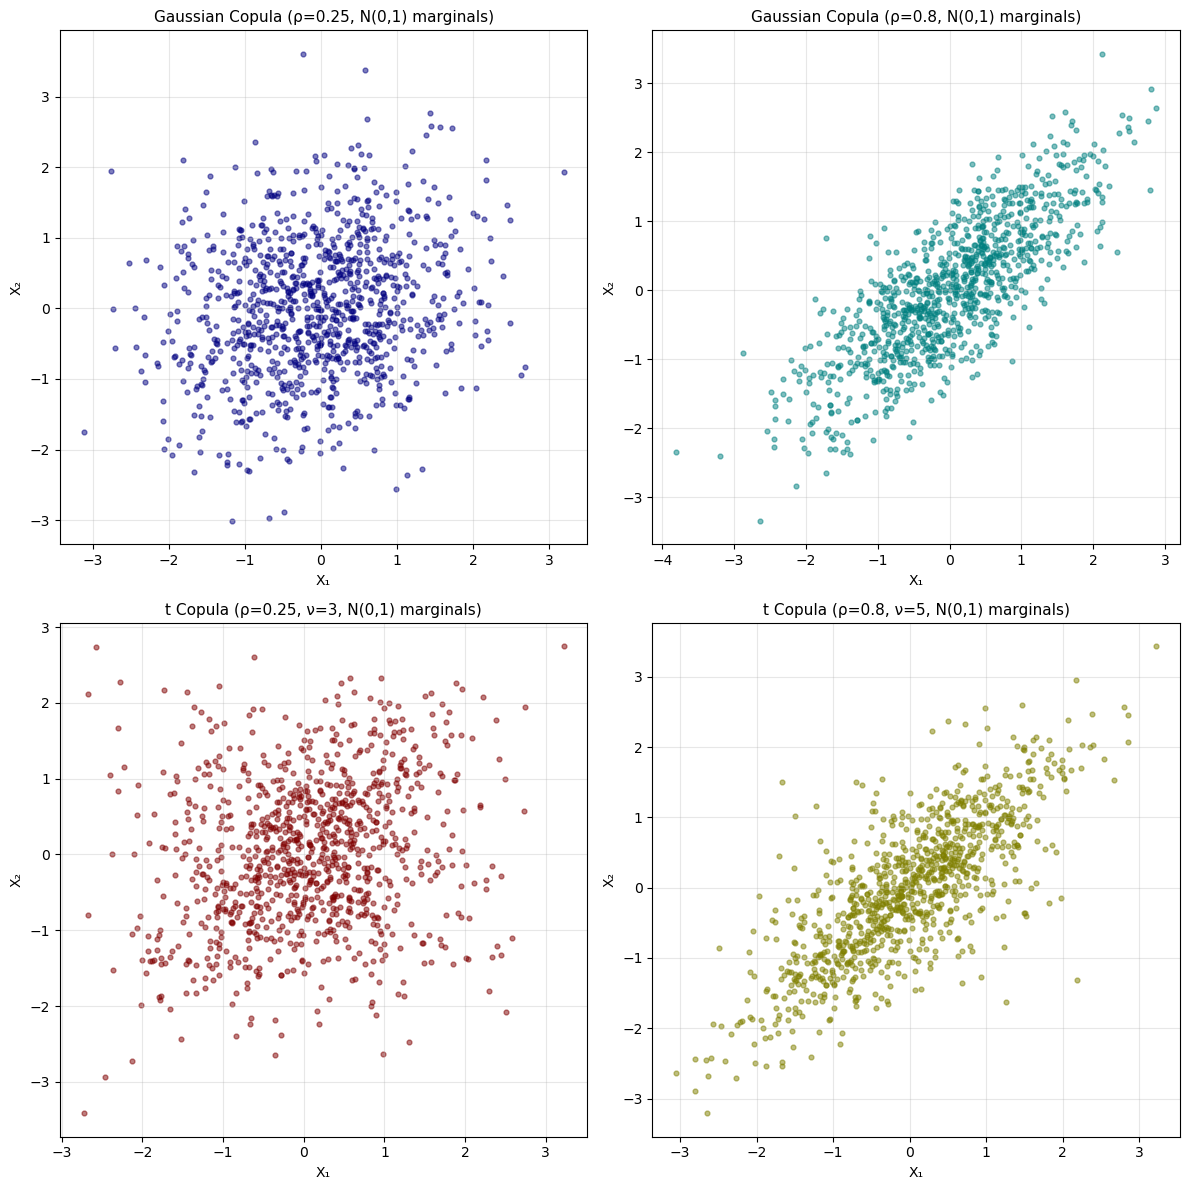

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Import the copula functions from parts (a) and (b)
def simulate_gaussian_copula(n_samples, rho):
    mean = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    Z1, Z2 = samples[:,0], samples[:,1]
    U1 = stats.norm.cdf(Z1)
    U2 = stats.norm.cdf(Z2)
    X1 = stats.norm.ppf(U1)
    X2 = stats.norm.ppf(U2)
    return X1, X2

def simulate_t_copula(n_samples, rho, nu):
    mean = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])
    Z = np.random.multivariate_normal(mean, cov, size=n_samples)
    Z1, Z2 = Z[:,0], Z[:,1]
    S = np.random.chisquare(nu, n_samples)
    scale = np.sqrt(nu / S)
    T1, T2 = Z1 * scale, Z2 * scale
    U1 = stats.t.cdf(T1, df=nu)
    U2 = stats.t.cdf(T2, df=nu)
    X1 = stats.norm.ppf(U1)
    X2 = stats.norm.ppf(U2)
    return X1, X2

# Set random seed for reproducibility
np.random.seed(42)
n_samples = 1000

# Simulate each scenario
X1_g25, X2_g25 = simulate_gaussian_copula(n_samples, rho=0.25)
X1_g80, X2_g80 = simulate_gaussian_copula(n_samples, rho=0.8)
X1_t25, X2_t25 = simulate_t_copula(n_samples, rho=0.25, nu=3)
X1_t80, X2_t80 = simulate_t_copula(n_samples, rho=0.8, nu=5)

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].scatter(X1_g25, X2_g25, alpha=0.5, s=12, color='navy')
axes[0, 0].set_title("Gaussian Copula (ρ=0.25, N(0,1) marginals)", fontsize=11)
axes[0, 0].set_xlabel("X₁"); axes[0, 0].set_ylabel("X₂"); axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(X1_g80, X2_g80, alpha=0.5, s=12, color='teal')
axes[0, 1].set_title("Gaussian Copula (ρ=0.8, N(0,1) marginals)", fontsize=11)
axes[0, 1].set_xlabel("X₁"); axes[0, 1].set_ylabel("X₂"); axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(X1_t25, X2_t25, alpha=0.5, s=12, color='maroon')
axes[1, 0].set_title("t Copula (ρ=0.25, ν=3, N(0,1) marginals)", fontsize=11)
axes[1, 0].set_xlabel("X₁"); axes[1, 0].set_ylabel("X₂"); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(X1_t80, X2_t80, alpha=0.5, s=12, color='olive')
axes[1, 1].set_title("t Copula (ρ=0.8, ν=5, N(0,1) marginals)", fontsize=11)
axes[1, 1].set_xlabel("X₁"); axes[1, 1].set_ylabel("X₂"); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("problem3c_copula_comparison.png", dpi=150)
plt.show()


## Problem 4
Pump failure data analysis using Bayesian hierarchical model.

Given data for 10 power plant pumps with failure counts $Y_i$ and operation times $t_i$:

| Pump i | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|--------|---|---|---|---|---|---|---|---|---|----| 
| $t_i$ | 94.3 | 15.7 | 62.9 | 126 | 5.24 | 31.4 | 1.05 | 1.05 | 2.1 | 10.5 |
| $Y_i$ | 5 | 1 | 5 | 14 | 3 | 19 | 1 | 1 | 4 | 22 |

Model: $Y_i \sim \text{Poisson}(\theta_i t_i)$, $\theta_i \sim \Gamma(\alpha, \beta)$, $\alpha = 1$, $\beta \sim \Gamma(0.2, 1)$

In [9]:
# Data for Problem 4
t = np.array([94.3, 15.7, 62.9, 126, 5.24, 31.4, 1.05, 1.05, 2.1, 10.5])
Y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])
n_pumps = len(t)

print("Pump failure data:")
print("Pump i:", list(range(1, n_pumps + 1)))
print("t_i:   ", t)
print("Y_i:   ", Y)
print("Rates: ", Y/t)

Pump failure data:
Pump i: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
t_i:    [ 94.3   15.7   62.9  126.     5.24  31.4    1.05   1.05   2.1   10.5 ]
Y_i:    [ 5  1  5 14  3 19  1  1  4 22]
Rates:  [0.05302227 0.06369427 0.07949126 0.11111111 0.57251908 0.60509554
 0.95238095 0.95238095 1.9047619  2.0952381 ]


### Problem 4a
Compute the full conditional posterior distributions for $\theta_i$ and $\beta$.

## Problem 4(a): Full Conditional Posterior Distributions

### **Model Setup**

- **Observed data for each pump $i = 1, \ldots, 10$:**
  - $Y_i$ = number of failures
  - $t_i$ = operation time (in thousands of hours)
  - **Likelihood:** $Y_i \mid \theta_i \sim \text{Poisson}(\theta_i t_i)$
- **Priors:**
  - $\theta_i \sim \text{Gamma}(\alpha, \beta)$ for all $i$
  - $\alpha = 1$
  - $\beta \sim \text{Gamma}(0.2, 1)$ (**shape 0.2, rate 1**)

---

### **Full Conditional for $\theta_i$**

- **Likelihood (up to constant):**
  $$
  p(Y_i \mid \theta_i) \propto \theta_i^{Y_i} e^{-\theta_i t_i}
  $$
- **Prior:**
  $$
  p(\theta_i \mid \beta) \propto \theta_i^{\alpha-1} e^{-\beta \theta_i}
  $$
- **Posterior (proportional to):**
  $$
  p(\theta_i \mid Y_i, t_i, \beta) \propto \theta_i^{Y_i + \alpha - 1} e^{-\theta_i (t_i + \beta)}
  $$
- **Conclusion:** This is a Gamma distribution:
  $$
  \boxed{
    \theta_i \mid Y_i, t_i, \beta \sim \text{Gamma}(Y_i + \alpha, \ t_i + \beta)
  }
  $$
  With $\alpha = 1$:
  $$
  \boxed{
    \theta_i \mid Y_i, t_i, \beta \sim \text{Gamma}(Y_i + 1, \ t_i + \beta)
  }
  $$

---

### **Full Conditional for $\beta$**

- **Prior:**
  $$
  p(\beta) \propto \beta^{0.2-1} e^{-\beta}
  $$
- **Marginal likelihood from all $\theta_i$'s:**
  $$
  \theta_i \mid \beta \sim \text{Gamma}(\alpha, \beta)
  \implies
  \prod_{i=1}^{n} \theta_i^{\alpha-1} e^{-\beta \theta_i} \beta^{n\alpha}
  $$
- **Posterior (proportional to):**
  $$
  p(\beta \mid \{\theta_i\}) \propto \beta^{n\alpha + 0.2 - 1} e^{-\beta(1 + \sum_{i=1}^n \theta_i)}
  $$
- **Conclusion:** This is a Gamma distribution:
  $$
  \boxed{
    \beta \mid \{\theta_i\} \sim \text{Gamma}(n\alpha + 0.2,\ 1 + \sum_{i=1}^n \theta_i)
  }
  $$
  With $\alpha = 1, n = 10$:
  $$
  \boxed{
    \beta \mid \{\theta_i\} \sim \text{Gamma}(10 + 0.2,\ 1 + \sum_{i=1}^{10} \theta_i)
  }
  $$

---

### **Parameterization Note**

- All Gamma distributions are in the **(shape, rate)** parameterization, i.e.:
  $$
  \text{Gamma}(a, b) \text{ has density } \frac{b^a}{\Gamma(a)} x^{a-1} e^{-bx}
  $$

---

#### **Summary Table**

| Quantity                | Full Conditional Posterior                |
|-------------------------|------------------------------------------|
| $\theta_i$            | $\text{Gamma}(Y_i+1, \ t_i+\beta)$      |
| $\beta$               | $\text{Gamma}(10.2, \ 1+\sum_{i=1}^{10} \theta_i)$ |



### Problem 4b
Formulate the Gibbs sampler for this problem.

In [10]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Problem 4(c): Gibbs Sampler for Pump Failure Data

# Data from the problem
Y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])  # Number of failures
t = np.array([94.3, 15.7, 62.9, 126, 5.24, 31.4, 1.05, 1.05, 2.1, 10.5])  # Operation time

n_pumps = 10
alpha = 1  # Fixed hyperparameter

def gibbs_sampler_pumps(Y, t, n_iter=10000, burn_in=2000):
    """
    Gibbs sampler for hierarchical Poisson-Gamma model
    
    Model:
    - Y_i ~ Poisson(theta_i * t_i)
    - theta_i ~ Gamma(alpha, beta)
    - alpha = 1 (fixed)
    - beta ~ Gamma(0.2, 1)
    
    Full conditionals:
    - theta_i | Y_i, t_i, beta ~ Gamma(Y_i + 1, t_i + beta)
    - beta | {theta_i} ~ Gamma(10.2, 1 + sum(theta_i))
    
    Parameters:
    -----------
    Y : array
        Observed failures for each pump
    t : array
        Operation time for each pump
    n_iter : int
        Total number of iterations
    burn_in : int
        Number of burn-in iterations to discard
    
    Returns:
    --------
    samples_theta : array of shape (n_iter - burn_in, n_pumps)
        Posterior samples of theta_i
    samples_beta : array of shape (n_iter - burn_in,)
        Posterior samples of beta
    """
    n_pumps = len(Y)
    
    # Initialize
    theta = Y / t  # Start with observed failure rates
    beta = 1.0
    
    # Storage for samples (after burn-in)
    samples_theta = np.zeros((n_iter - burn_in, n_pumps))
    samples_beta = np.zeros(n_iter - burn_in)
    
    # Gibbs sampling
    for iteration in range(n_iter):
        # Step 1: Update each theta_i
        for i in range(n_pumps):
            shape = Y[i] + 1
            rate = t[i] + beta
            # Note: scipy.stats.gamma uses scale = 1/rate
            theta[i] = stats.gamma.rvs(a=shape, scale=1/rate)
        
        # Step 2: Update beta
        shape = 10 * alpha + 0.2  # = 10.2 since alpha = 1
        rate = 1 + np.sum(theta)
        beta = stats.gamma.rvs(a=shape, scale=1/rate)
        
        # Store samples after burn-in
        if iteration >= burn_in:
            idx = iteration - burn_in
            samples_theta[idx, :] = theta
            samples_beta[idx] = beta
    
    return samples_theta, samples_beta


# Run the Gibbs sampler
print("="*70)
print("Problem 4(c): Gibbs Sampler for Pump Failure Data")
print("="*70)
print(f"\nData:")
print(f"Number of pumps: {n_pumps}")
print(f"Failures Y: {Y}")
print(f"Operation times t: {t}")
print(f"\nRunning Gibbs sampler with 10,000 iterations (2,000 burn-in)...")

np.random.seed(42)
samples_theta, samples_beta = gibbs_sampler_pumps(Y, t, n_iter=10000, burn_in=2000)

print(f"✓ Generated {len(samples_beta)} posterior samples")

# Summary statistics
print("\n" + "="*70)
print("POSTERIOR SUMMARY STATISTICS")
print("="*70)
print(f"\nβ (hyperparameter):")
print(f"  Posterior mean: {np.mean(samples_beta):.4f}")
print(f"  Posterior std:  {np.std(samples_beta):.4f}")
print(f"  95% CI: [{np.percentile(samples_beta, 2.5):.4f}, {np.percentile(samples_beta, 97.5):.4f}]")

print(f"\nθ₁ (Pump 1 failure rate):")
print(f"  Posterior mean: {np.mean(samples_theta[:, 0]):.4f}")
print(f"  Posterior std:  {np.std(samples_theta[:, 0]):.4f}")
print(f"  95% CI: [{np.percentile(samples_theta[:, 0], 2.5):.4f}, {np.percentile(samples_theta[:, 0], 97.5):.4f}]")

print(f"\nθ₂ (Pump 2 failure rate):")
print(f"  Posterior mean: {np.mean(samples_theta[:, 1]):.4f}")
print(f"  Posterior std:  {np.std(samples_theta[:, 1]):.4f}")
print(f"  95% CI: [{np.percentile(samples_theta[:, 1], 2.5):.4f}, {np.percentile(samples_theta[:, 1], 97.5):.4f}]")

print("="*70)


Problem 4(c): Gibbs Sampler for Pump Failure Data

Data:
Number of pumps: 10
Failures Y: [ 5  1  5 14  3 19  1  1  4 22]
Operation times t: [ 94.3   15.7   62.9  126.     5.24  31.4    1.05   1.05   2.1   10.5 ]

Running Gibbs sampler with 10,000 iterations (2,000 burn-in)...
✓ Generated 8000 posterior samples

POSTERIOR SUMMARY STATISTICS

β (hyperparameter):
  Posterior mean: 1.3569
  Posterior std:  0.4915
  95% CI: [0.5922, 2.5008]

θ₁ (Pump 1 failure rate):
  Posterior mean: 0.0632
  Posterior std:  0.0257
  95% CI: [0.0233, 0.1221]

θ₂ (Pump 2 failure rate):
  Posterior mean: 0.1186
  Posterior std:  0.0841
  95% CI: [0.0155, 0.3338]


### Problem 4c
Plot the marginal posterior densities of $\beta$, $\theta_1$ and $\theta_7$ (3 plots).


✓ Plots saved as 'problem4c_posteriors.png'


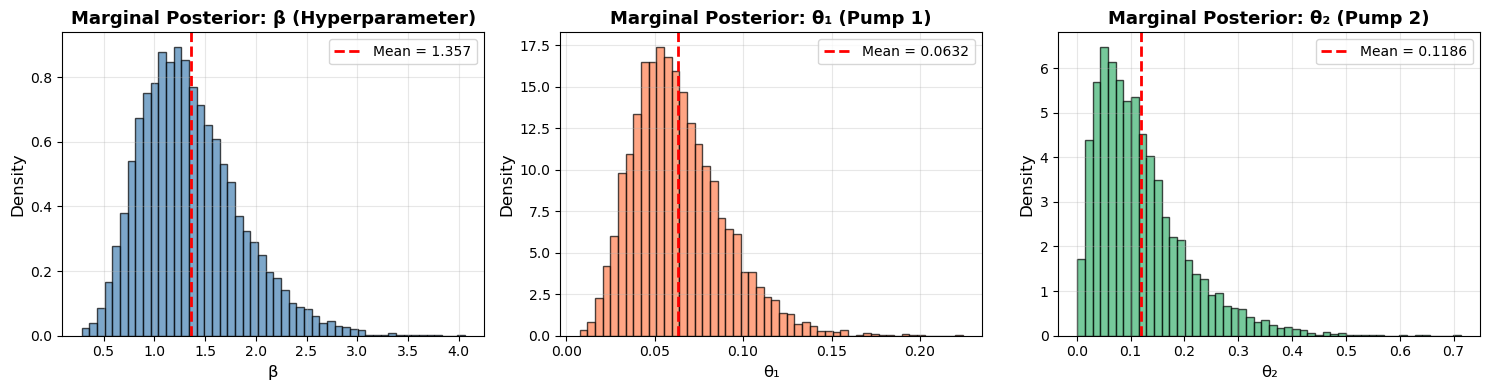

✓ Trace plots saved as 'problem4c_traces.png'


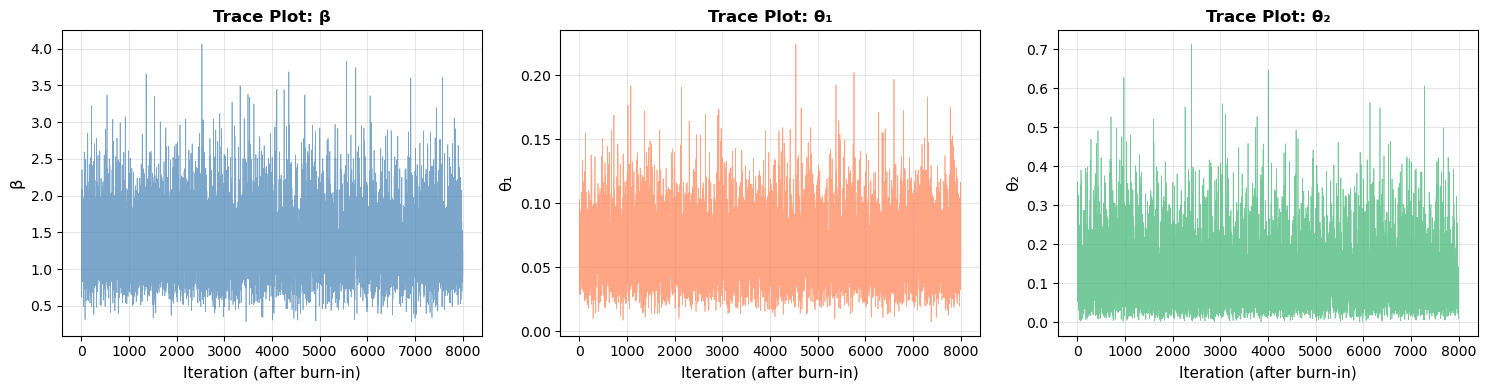

In [11]:

# Create the 3 required plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Marginal posterior density of β
axes[0].hist(samples_beta, bins=50, density=True, alpha=0.7, 
             edgecolor='black', color='steelblue')
axes[0].axvline(np.mean(samples_beta), color='red', linestyle='--', 
                linewidth=2, label=f'Mean = {np.mean(samples_beta):.3f}')
axes[0].set_xlabel('β', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Marginal Posterior: β (Hyperparameter)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Marginal posterior density of θ₁
axes[1].hist(samples_theta[:, 0], bins=50, density=True, alpha=0.7, 
             edgecolor='black', color='coral')
axes[1].axvline(np.mean(samples_theta[:, 0]), color='red', linestyle='--', 
                linewidth=2, label=f'Mean = {np.mean(samples_theta[:, 0]):.4f}')
axes[1].set_xlabel('θ₁', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Marginal Posterior: θ₁ (Pump 1)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Marginal posterior density of θ₂
axes[2].hist(samples_theta[:, 1], bins=50, density=True, alpha=0.7, 
             edgecolor='black', color='mediumseagreen')
axes[2].axvline(np.mean(samples_theta[:, 1]), color='red', linestyle='--', 
                linewidth=2, label=f'Mean = {np.mean(samples_theta[:, 1]):.4f}')
axes[2].set_xlabel('θ₂', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Marginal Posterior: θ₂ (Pump 2)', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problem4c_posteriors.png', dpi=300, bbox_inches='tight')
print("\n✓ Plots saved as 'problem4c_posteriors.png'")
plt.show()

# Additional diagnostic: trace plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(samples_beta, linewidth=0.5, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Iteration (after burn-in)', fontsize=11)
axes[0].set_ylabel('β', fontsize=12)
axes[0].set_title('Trace Plot: β', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(samples_theta[:, 0], linewidth=0.5, alpha=0.7, color='coral')
axes[1].set_xlabel('Iteration (after burn-in)', fontsize=11)
axes[1].set_ylabel('θ₁', fontsize=12)
axes[1].set_title('Trace Plot: θ₁', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(samples_theta[:, 1], linewidth=0.5, alpha=0.7, color='mediumseagreen')
axes[2].set_xlabel('Iteration (after burn-in)', fontsize=11)
axes[2].set_ylabel('θ₂', fontsize=12)
axes[2].set_title('Trace Plot: θ₂', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problem4c_traces.png', dpi=300, bbox_inches='tight')
print("✓ Trace plots saved as 'problem4c_traces.png'")
plt.show()
